## Candidate class to analyse single pulses

First install [your](https://github.com/devanshkv/your).

In [1]:
!pip install git+https://github.com/devanshkv/your.git

  Cloning https://github.com/devanshkv/your.git to /tmp/pip-req-build-61ucrjvc
  Running command git clone -q https://github.com/devanshkv/your.git /tmp/pip-req-build-61ucrjvc
  Created wheel for your: filename=your-0.4.9-py3-none-any.whl size=74197 sha256=85f02f58e4325ee20075f9f462e7da1862564c15f16e4b9f581c76f15d326c8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-do3q62s2/wheels/af/ea/8e/0af2a86dd7ff7d8e91bf3e3d81d82853b1641f749d72144e32
Successfully built your


In [2]:
from your.candidate import Candidate
from your.utils.plotter import plot_h5
import numpy as np
from scipy.signal import detrend
import os

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
%matplotlib inline

In [3]:
import pylab as plt
import logging

logger = logging.getLogger()
logger = logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(threadName)s - %(levelname)s -" " %(message)s",
)

First, we make the candiate object with the relevant paramters of the candidate.

In [4]:
import tarfile
import tempfile
from urllib.request import urlretrieve

In [5]:
temp_dir = tempfile.TemporaryDirectory()
download_path = str(temp_dir.name) + "/askap_frb_180417.tgz"
url = "http://astro.phys.wvu.edu/files/askap_frb_180417.tgz"
urlretrieve(
    url, download_path,
)
frb_tar = tarfile.open(download_path)
frb_tar.extractall(path=os.path.dirname(download_path))
fil_file = temp_dir.name + "/28.fil"

In [6]:
# creating the candidate object with a certain dm, label, snr, tcand and width
cand = Candidate(
    fp=fil_file,
    dm=475.28400,
    tcand=2.0288800,
    width=2,
    label=-1,
    snr=16.8128,
    min_samp=256,
    device=0,
)

Get data, this will take data from the filterbank file, and can be accessed from `cand.data`:

In [7]:
cand.get_chunk()
print(cand.data, cand.data.shape, cand.dtype)

[[124 114 143 ... 145 118 159]
 [108 158 129 ... 122 142 158]
 [122 123 131 ... 119 142 129]
 ...
 [114 113 142 ... 120 141 160]
 [120 113 103 ... 146 107 136]
 [139 133 113 ... 146 141 160]] (991, 336) <class 'numpy.uint8'>


Here is our dispersed pulse (it is weak to see)

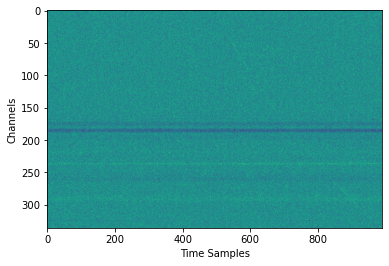

In [8]:
plt.imshow(cand.data.T, aspect="auto", interpolation=None)
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

Now let's make the DM Time plot.

**Note:** This may take a while. 

In [9]:
cand.dmtime()

Using <class 'str'>:
/tmp/tmpj_qy7j6q/28.fil

The DM time data can be accessed using `cand.dmt`. Let's have a look: 

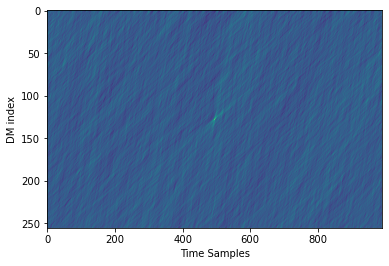

In [10]:
plt.imshow(cand.dmt, aspect="auto", interpolation=None)
plt.ylabel("DM index")
plt.xlabel("Time Samples")
plt.show()

We can see the bow-tie shape and the peak in the middle in the above plot. Now let's dedisperse the data!

In [11]:
cand.dedisperse()

Using <class 'str'>:
/tmp/tmpj_qy7j6q/28.fil

The dedispersed frequency-time can be obtained using `cand.dedispersed`

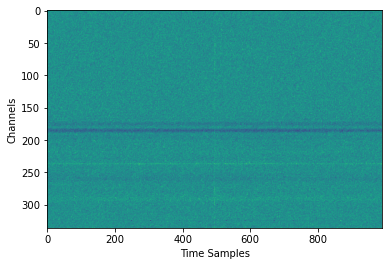

In [12]:
plt.imshow(cand.dedispersed.T, aspect="auto", interpolation=None)
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

The FRB is weakly visible in the middle of the plot. To see the FRB pulse profile let's plot the time series 

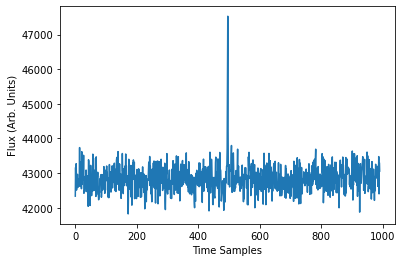

In [13]:
plt.plot(cand.dedispersed.T.sum(0))
plt.xlabel("Time Samples")
plt.ylabel("Flux (Arb. Units)")
plt.show()

[Detrending](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) can be used to remove bandpass variations.

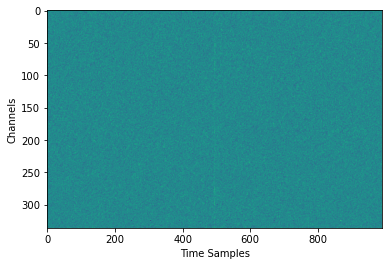

In [14]:
plt.imshow(detrend(cand.dedispersed.T), aspect="auto", interpolation=None)
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

We can have a look at the bandpass with and without [detrending](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) .

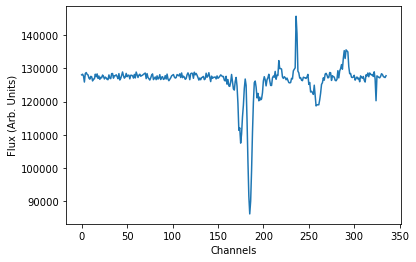

In [15]:
# Without detrend
plt.plot(cand.dedispersed.T.sum(1))
plt.xlabel("Channels")
plt.ylabel("Flux (Arb. Units)")
plt.show()

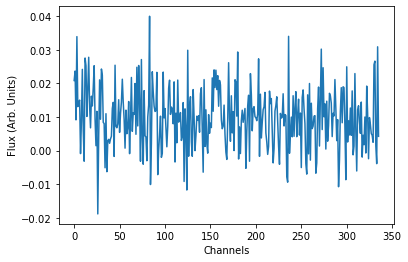

In [16]:
# With detrend
plt.plot(detrend(cand.dedispersed.T).sum(1))
plt.xlabel("Channels")
plt.ylabel("Flux (Arb. Units)")
plt.show()

Single pulse search pipelines lines often report approimate DMs. We can find the DM which maximizes our Signal to Noise Ratio (SNR) using the [`optimize_dm`](https://devanshkv.github.io/your/candidate/#optimize_dm) method. We assume that the DM vs -SNR curve is a convex function and use [`golden`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.golden.html) method to find the minima. The function returns optimal DM and SNR.

**Note** This is an experimental feature. 

In [17]:
cand.optimize_dm()
print(f"Heimdall reported dm: {cand.dm}, Optimised DM: {cand.dm_opt}")
print(f"Heimdall reported snr: {cand.snr}, SNR at Opt. DM: {cand.snr_opt}")

Heimdall reported dm: 475.284, Optimised DM: 474.7613272736851
Heimdall reported snr: 16.8128, SNR at Opt. DM: 14.077508926391602


For now, let's enter `-1` as values for `dm_opt` and `snr_opt`

In [18]:
cand.dm_opt = -1
cand.snr_opt = -1

Each candiate gets a unique ID which can be accessed using `cand.id`

In [19]:
cand.id

'cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280'

Now let's save our candidate in an h5 file

In [20]:
fout = cand.save_h5()
print(fout)

2020-08-26 17:02:03,878 - your.candidate - MainThread - INFO - Saving h5 file cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5.


cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5


We will use [`plot_h5`](https://devanshkv.github.io/your/utils/plotter/#plot_h5) function to plot the candidate h5 we just generated.

2020-08-26 17:02:07,884 - root - MainThread - WARNING - Lengh of time axis is not 256. This data is probably not pre-processed.


<Figure size 432x288 with 0 Axes>

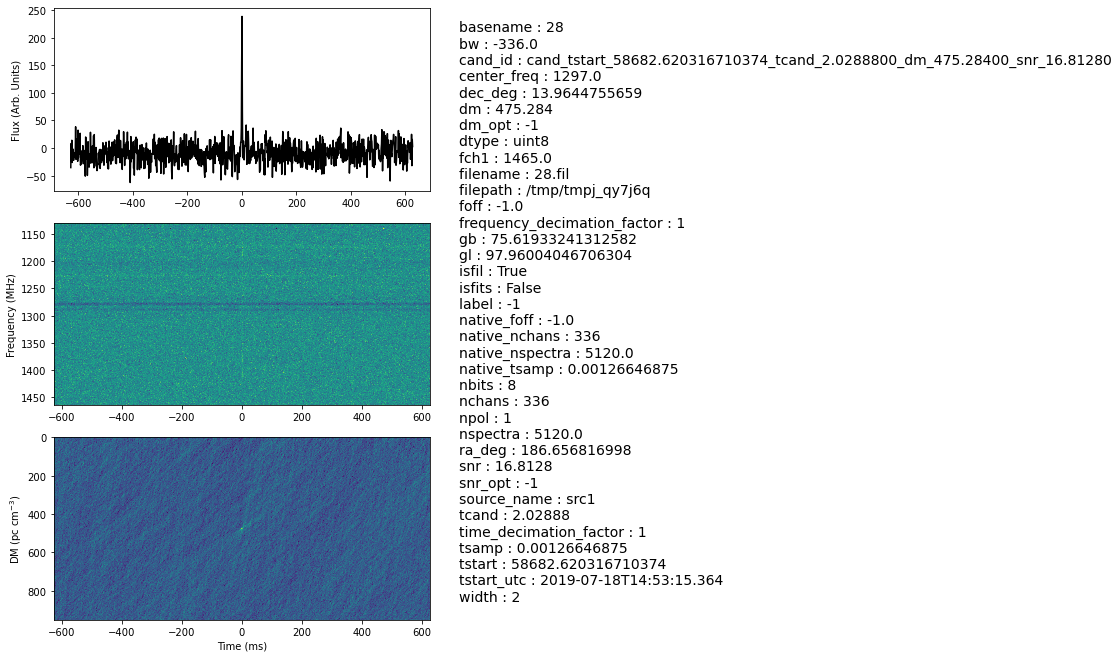

In [21]:
plot_h5(fout, detrend_ft=False, save=True)

We can also create publication quality plots right here using `publication=True` argument.

2020-08-26 17:02:16,684 - root - MainThread - WARNING - Lengh of time axis is not 256. This data is probably not pre-processed.


<Figure size 432x288 with 0 Axes>

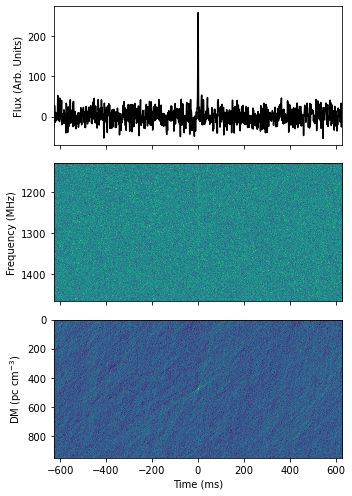

In [22]:
plot_h5(fout, detrend_ft=True, save=True, publication=True)

## Reshaping Freq-time and DM-time arrays

In [23]:
dedispersed_bkup = cand.dedispersed
dmt_bkup = cand.dmt

In [24]:
print(f"Shape of dedispersed (frequency-time) data: {dedispersed_bkup.T.shape}")
print(f"Shape of DM-time data: {dmt_bkup.shape}")

Shape of dedispersed (frequency-time) data: (336, 991)
Shape of DM-time data: (256, 991)


In [25]:
time_size = 256
freq_size = 256

## Using resize in skimage.transform for reshaping

In [26]:
# resize dedispersed Frequency-time array along frequency axis
logging.info(f"Resizing time axis")
cand.resize(key="ft", size=time_size, axis=0, anti_aliasing=True)
logging.info(
    f"Shape of dedispersed (frequency-time) data after resizing: {cand.dedispersed.T.shape}"
)

# resize dedispersed Frequency-time array along time axis
logging.info(f"Resizing frequency axis")
cand.resize(key="ft", size=freq_size, axis=1, anti_aliasing=True)
logging.info(
    f"Shape of dedispersed (frequency-time) data after resizing: {cand.dedispersed.T.shape}"
)

2020-08-26 17:02:24,916 - root - MainThread - INFO - Resizing time axis
2020-08-26 17:02:25,065 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after resizing: (336, 256)
2020-08-26 17:02:25,076 - root - MainThread - INFO - Resizing frequency axis
2020-08-26 17:02:25,099 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after resizing: (256, 256)


In [27]:
# resize DM-time array along time axis
cand.resize(key="dmt", size=time_size, axis=1, anti_aliasing=True)
logging.info(f"Shape of DM-time data after resizing: {cand.dmt.shape}")

2020-08-26 17:02:25,160 - root - MainThread - INFO - Shape of DM-time data after resizing: (256, 256)


## Using decimate for reshaping

In [28]:
from candidate import crop

In [29]:
cand.dedispersed = dedispersed_bkup
cand.dmt = dmt_bkup

In [30]:
logging.info(f"Shape of dedispersed (frequency-time) data: {cand.dedispersed.T.shape}")

2020-08-26 17:02:25,266 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data: (336, 991)


In [31]:
# Let's use pulse width to decide the decimate factor by which to collape the time axis
pulse_width = cand.width
if pulse_width == 1:
    time_decimate_factor = 1
else:
    time_decimate_factor = pulse_width // 2

freq_decimation_factor = cand.dedispersed.shape[1] // freq_size
logging.info(f"Time decimation factor is {time_decimate_factor}")
logging.info(f"Frequency decimation factor is {freq_decimation_factor}")

2020-08-26 17:02:25,311 - root - MainThread - INFO - Time decimation factor is 1
2020-08-26 17:02:25,321 - root - MainThread - INFO - Frequency decimation factor is 1


Let's set the factors to something more interesting than 1

In [32]:
time_decimate_factor = 2
frequency_decimate_factor = 2

In [33]:
# Decimating time axis, and cropping to the final size
cand.decimate(
    key="ft", axis=0, pad=True, decimate_factor=time_decimate_factor, mode="median"
)
logging.info(
    f"Shape of dedispersed (frequency-time) data after time decimation: {cand.dedispersed.T.shape}"
)

# Cropping the time axis to a required size
crop_start_sample_ft = cand.dedispersed.shape[0] // 2 - time_size // 2
cand.dedispersed = crop(cand.dedispersed, crop_start_sample_ft, time_size, 0)
logging.info(
    f"Shape of dedispersed (frequency-time) data after time decimation + crop: {cand.dedispersed.T.shape}"
)

# Decimating frequency axis
cand.decimate(
    key="ft", axis=1, pad=True, decimate_factor=frequency_decimate_factor, mode="median"
)
logging.info(
    f"Shape of dedispersed (frequency-time) data after decimation: {cand.dedispersed.T.shape}"
)

2020-08-26 17:02:25,405 - your.utils.misc - MainThread - INFO - padding along axis 0
2020-08-26 17:02:25,450 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after time decimation: (336, 496)
2020-08-26 17:02:25,462 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after time decimation + crop: (336, 256)
2020-08-26 17:02:25,466 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after decimation: (168, 256)


In [34]:
# Reshaping the DM-time using decimation
# Decimating time axis and croppig to the final required size
logging.info(f"Original shape of DM-time data after time decimation: {cand.dmt.shape}")
cand.decimate(
    key="dmt", axis=1, pad=True, decimate_factor=time_decimate_factor, mode="median"
)
logging.info(f"Shape of DM-time data after time decimation: {cand.dmt.shape}")

crop_start_sample_dmt = cand.dmt.shape[1] // 2 - time_size // 2
cand.dmt = crop(cand.dmt, crop_start_sample_dmt, time_size, 1)

logging.info(f"Shape of DM-time data after time decimation + crop: {cand.dmt.shape}")

2020-08-26 17:02:25,493 - root - MainThread - INFO - Original shape of DM-time data after time decimation: (256, 991)
2020-08-26 17:02:25,509 - your.utils.misc - MainThread - INFO - padding along axis 1
2020-08-26 17:02:25,535 - root - MainThread - INFO - Shape of DM-time data after time decimation: (256, 496)
2020-08-26 17:02:25,551 - root - MainThread - INFO - Shape of DM-time data after time decimation + crop: (256, 256)


Let's take a final look at the data. Decimation reduces the standard deviation of the data so the candidates should look more significant now. 

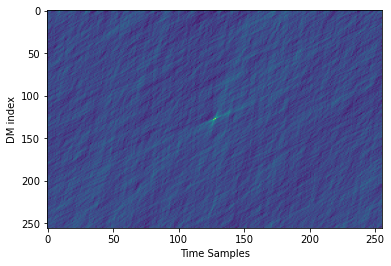

In [35]:
plt.imshow(cand.dmt, aspect="auto")
plt.ylabel("DM index")
plt.xlabel("Time Samples")
plt.show()

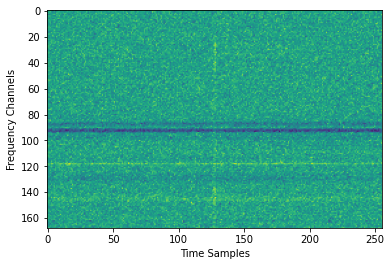

In [36]:
plt.imshow(cand.dedispersed.T, aspect="auto")
plt.ylabel("Frequency Channels")
plt.xlabel("Time Samples")
plt.show()

We can save this decimated data to h5 files using the same command as before

In [37]:
fout = cand.save_h5()
print(fout)

2020-08-26 17:02:29,344 - your.candidate - MainThread - INFO - Saving h5 file cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5.


cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5


2020-08-26 17:02:29,801 - root - MainThread - WARNING - Lengh of time axis is not 256. This data is probably not pre-processed.


<Figure size 432x288 with 0 Axes>

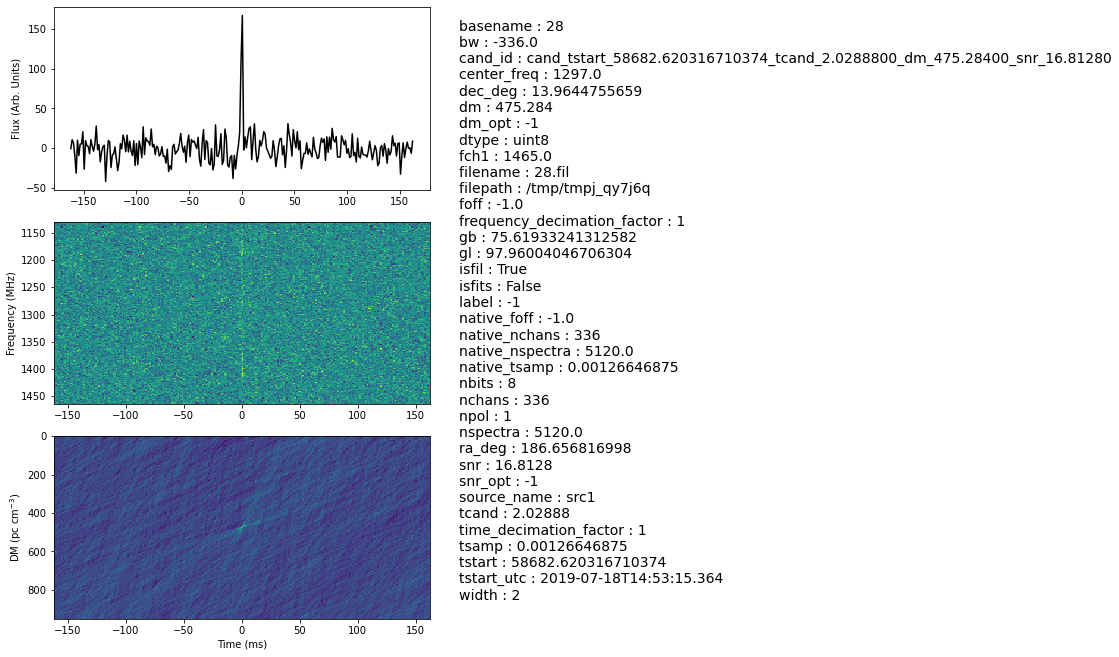

In [38]:
# Let's also detrend to remove the bandpass variations
plot_h5(fout, detrend_ft=True, save=True)